In [6]:
!pip install tensorflow==2.15 
!pip install gradio

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

In [7]:
dataset_dir= r"C:\Users\ASUS\Desktop\archive\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [9]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [10]:

# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [11]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


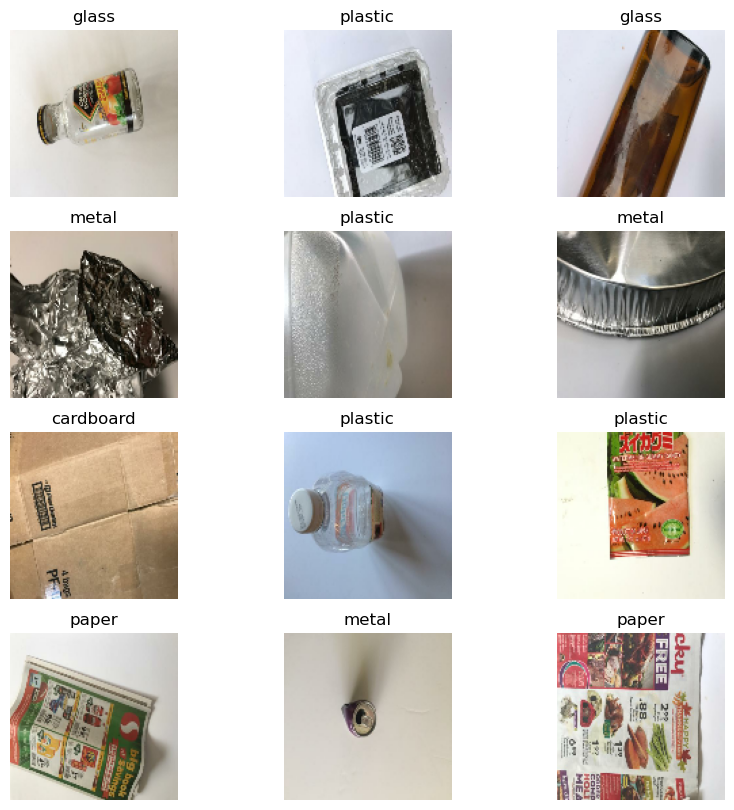

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [13]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts


In [14]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [15]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


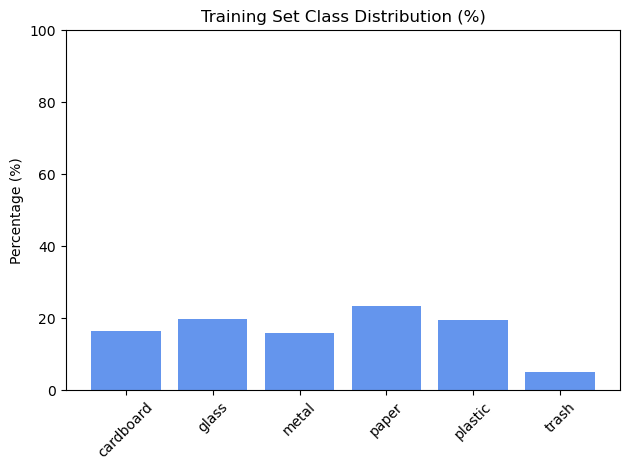

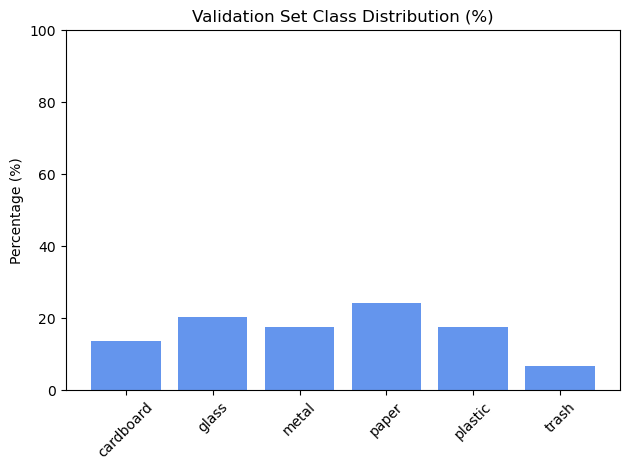

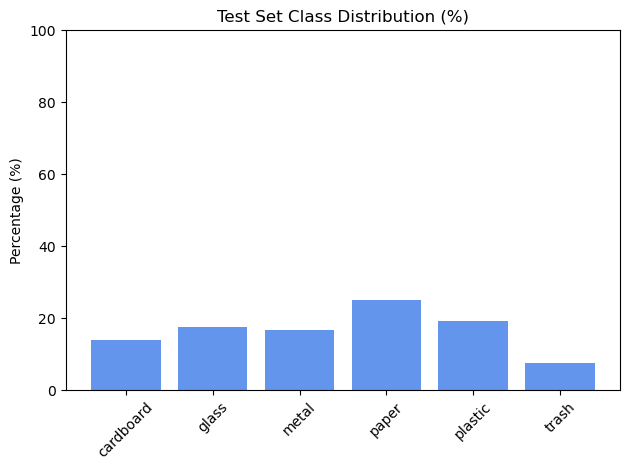

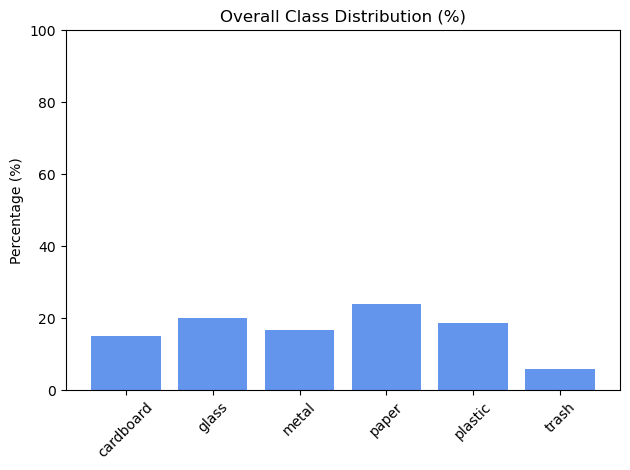

In [16]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [17]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):  # handle one-hot encoded case
            label = np.argmax(label)
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),  # use actual labels present in the data
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}



In [20]:


print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [23]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [24]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



In [25]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [27]:
# Fix class_weights to reindex from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [28]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 124, 124, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 4, 4, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 6)                 8454      
                                                                 
Total params: 8777828 (33.48 MB)
Trainable params: 797

In [29]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 124, 124, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 124, 124, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 124, 124, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 62, 62, 32)           864       ['normalizatio

Epoch 1/10


64/64 [==============================] - 99s 757ms/step - loss: 1.5347 - accuracy: 0.3996 - val_loss: 1.1160 - val_accuracy: 0.6475
Epoch 2/10
64/64 [==============================] - 44s 694ms/step - loss: 0.9280 - accuracy: 0.7033 - val_loss: 0.7410 - val_accuracy: 0.7901
Epoch 3/10
64/64 [==============================] - 44s 693ms/step - loss: 0.6166 - accuracy: 0.8081 - val_loss: 0.5614 - val_accuracy: 0.8277
Epoch 4/10
64/64 [==============================] - 44s 690ms/step - loss: 0.4514 - accuracy: 0.8487 - val_loss: 0.4511 - val_accuracy: 0.8416
Epoch 5/10
64/64 [==============================] - 44s 694ms/step - loss: 0.3302 - accuracy: 0.8956 - val_loss: 0.4212 - val_accuracy: 0.8515
Epoch 6/10
64/64 [==============================] - 45s 696ms/step - loss: 0.2958 - accuracy: 0.9016 - val_loss: 0.3780 - val_accuracy: 0.8614
Epoch 7/10
64/64 [==============================] - 44s 689ms/step - loss: 0.2292 - accuracy: 0.9283 - val_loss: 0.3484 - val_accuracy: 0.87

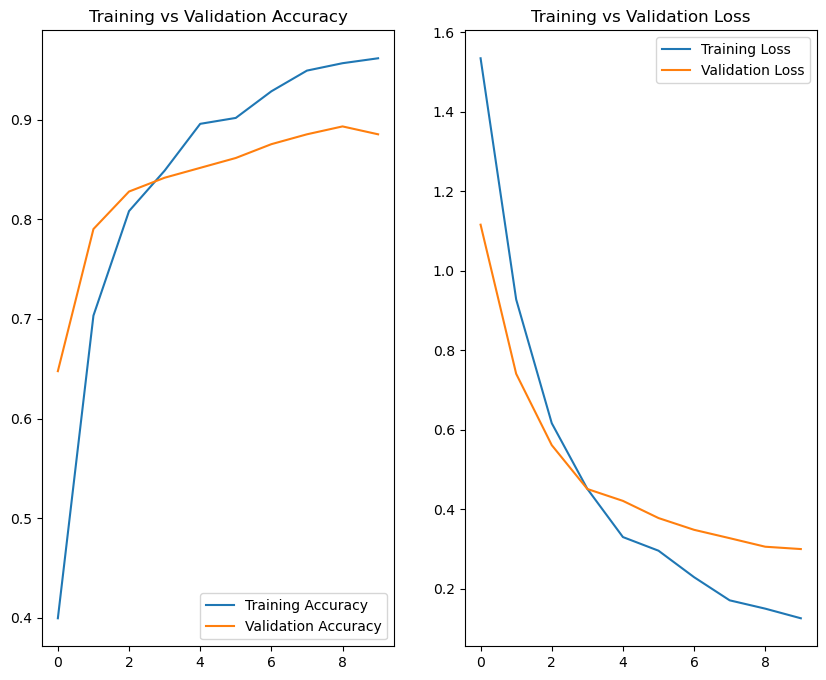

In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [31]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 [==============================] - 2s 246ms/step - loss: 0.2537 - accuracy: 0.9023
Test accuracy is0.9023, Test loss is 0.2537


In [32]:

# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 [==============================] - 6s 237ms/step
[[26  0  0  3  0  0]
 [ 0 44  9  0  1  0]
 [ 0  0 42  0  0  0]
 [ 2  0  0 73  0  1]
 [ 0  3  1  0 33  5]
 [ 0  0  0  0  0 13]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        29
           1       0.94      0.81      0.87        54
           2       0.81      1.00      0.89        42
           3       0.96      0.96      0.96        76
           4       0.97      0.79      0.87        42
           5       0.68      1.00      0.81        13

    accuracy                           0.90       256
   macro avg       0.88      0.91      0.89       256
weighted avg       0.91      0.90      0.90       256



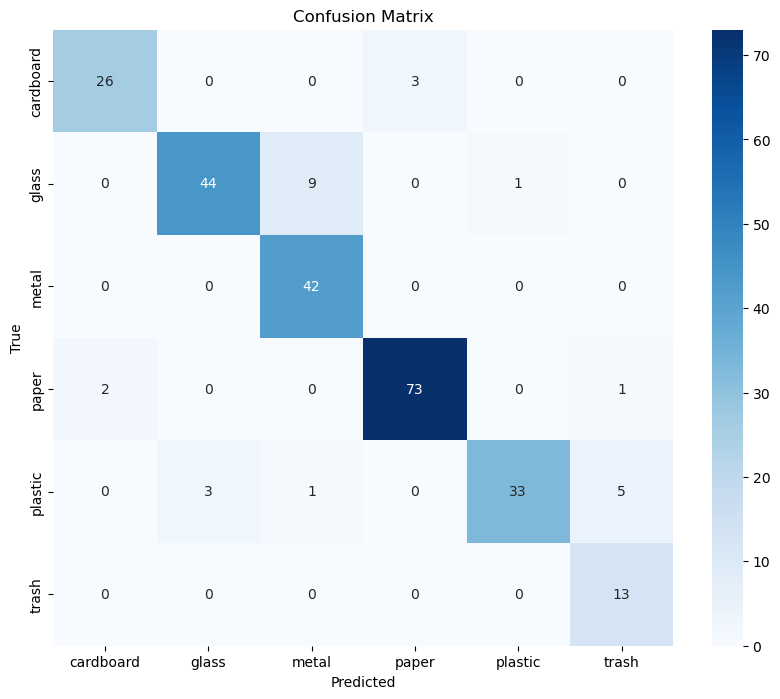

In [33]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 [==============================] - 4s 4s/step


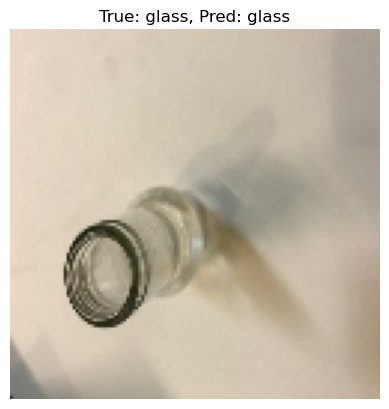

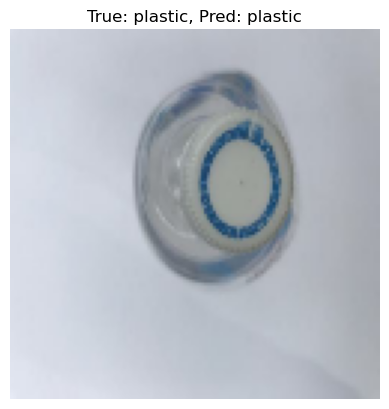

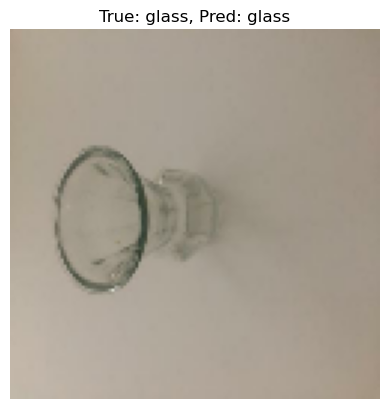

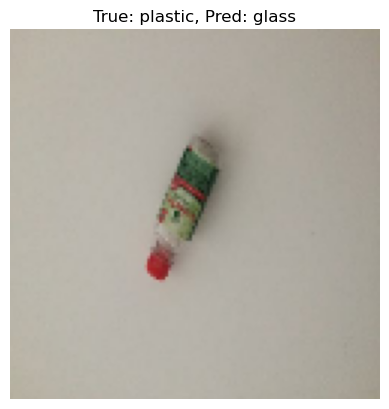

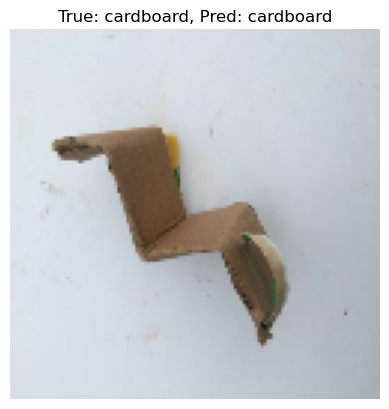

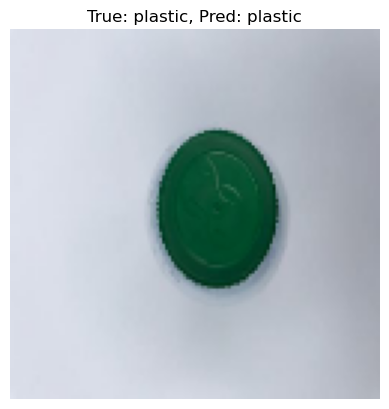

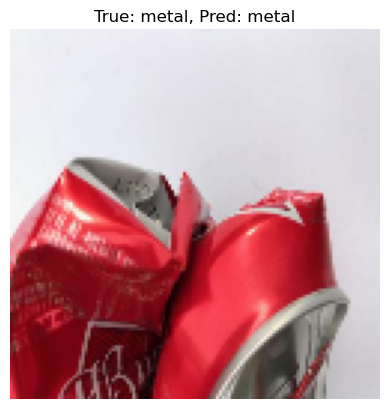

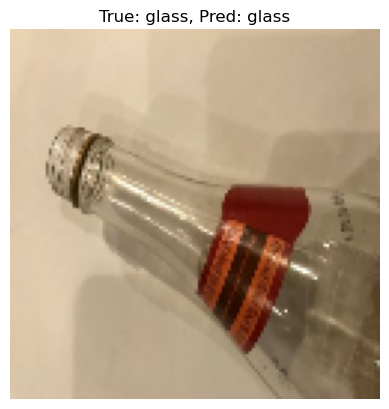

In [34]:

# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [35]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [36]:
!pip install gradio

In [37]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [38]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [46]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction  

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "D:\Jupyter notebook\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Jupyter notebook\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Jupyter notebook\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "D:\Jupyter notebook\Lib\site-packages\starlette\applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "D:\Jupyter notebook\Lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "D:\Jupyter notebook\Lib\site-packages\starlette\middleware\errors.py", line 165, i

1/1 [==============================] - 0s 48ms/step


# Conclusion:

Garbage classification plays a vital role in promoting environmental sustainability, reducing pollution, and improving waste management efficiency. By correctly sorting waste into categories like biodegradable, recyclable, hazardous, and non-recyclable, we can enhance recycling processes, conserve natural resources, and minimize landfill usage. Implementing proper garbage classification at individual, community, and industrial levels is essential for creating cleaner cities and ensuring a healthier planet for future generations.